In [1]:
import numpy as np
import pandas as pd
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans, SpectralClustering
import matplotlib.pyplot as plt
import seaborn as sbn
from sklearn.datasets import load_iris, load_digits
from sklearn.manifold import TSNE
from sklearn import metrics
from sklearn.model_selection import train_test_split
# from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, rand_score
# from sklearn.metrics.cluster import contingency_matrix
import random
import warnings
warnings.filterwarnings('ignore')

In [2]:
random.seed(2)

In [3]:
Q4_VISUALIZATION_BASE_PATH = '../../visualizations/Q4/'

In [4]:
class CustomDataset:
    def __init__(self, data, target):
        self.data = data
        self.target = target

In [5]:
def get_dataset(name='iris'):
    if name == 'iris':
        data = load_iris()
        return data
    if name == 'digits':
        data = load_digits()
        return data
    if name == 'customer-amex':
        data = CustomDataset(
            pd.read_csv('../../data/customer-amex/train_data.csv', nrows=1000),
            pd.read_csv('../../data/customer-amex/train_labels.csv', nrows=1000)
        )
        return data
    if name == 'credit_card':
        all_data = pd.read_csv('../../data/density_based_clustering_data.csv')
        data = CustomDataset(
            all_data.loc[:, all_data.columns != 'class'].to_numpy(),
            all_data.loc[:, all_data.columns == 'class'].to_numpy().flatten()
        )
        return data

def get_tsne(X):

    X_embedded = TSNE(learning_rate='auto', init='random').fit_transform(X)
    return X_embedded

def get_tsne_plot(X, Y, title='TSNE Plot', save=False, img_name=None):
    data_embedded_combined = pd.DataFrame(data=np.c_[X, Y], columns=['x', 'y'] + ['target'])
    sbn.lmplot(data=data_embedded_combined, x='x', y='y', hue='target', fit_reg=False)
    plt.title(title)
    if(save == True):
        plt.savefig(Q4_VISUALIZATION_BASE_PATH + img_name, bbox_inches='tight')
    # plt.show()


In [6]:
def adjusted_rand_index(labels, clusters):
    return metrics.adjusted_rand_score(labels, clusters)

def adjusted_mutual_information(labels, clusters):
    return metrics.adjusted_mutual_info_score(labels, clusters)

def purity_score(labels, clusters):
    cont_matrix = metrics.cluster.contingency_matrix(labels, clusters)
    return np.sum(np.amax(cont_matrix, axis=0)) / np.sum(cont_matrix)

def silhoutte_coefficient(X, clusters):
    return metrics.silhouette_score(X, clusters)

def calinski_harabasz_index(X, clusters):
    return metrics.calinski_harabasz_score(X, clusters)

def davies_bouldin_index(X, clusters):
    return metrics.davies_bouldin_score(X, clusters)

def extrinsic_measures(labels, clusters):
    return {
        'adjusted_rand_index': adjusted_rand_index(labels, clusters),
        'adjusted_mutual_information': adjusted_mutual_information(labels, clusters)
    }

def intrinsic_measures(X, clusters):
    return {
        'silhoutte_coefficient': silhoutte_coefficient(X, clusters),
        'calinski_harabasz_index': calinski_harabasz_index(X, clusters),
        'davies_bouldin_index': davies_bouldin_index(X, clusters)
    }

In [7]:
def print_all_intrinsic(intrinsic_measures):
    for key in intrinsic_measures:
        print(f"{key} : {intrinsic_measures[key]}")
def print_all_extrinsic(extrinsic_measures):
    for key in extrinsic_measures:
        print(f"{key} : {extrinsic_measures[key]}")

K-Means Algorithm

In [8]:
def get_kmeans_model(n_clusters, max_iter=300):
    model = KMeans(n_clusters, max_iter=max_iter, init='random')
    return model
def perform_kmeans_clustering(model, X):
    model.fit(X)
    clusters = model.labels_
    return model, clusters

In [9]:
def kmeans_hyperparameter_tuning(X, Y, n_cluster, max_iters):
    extrinsic = {}
    intrinsic = {}
    
    for max_iter in max_iters:
        model = KMeans(n_clusters=n_cluster, max_iter=max_iter, init='random')
        model, clusters = perform_kmeans_clustering(model, X)
        extrinsic_measures_i = extrinsic_measures(Y, clusters)
        instrinsic_measures_i = intrinsic_measures(X, clusters)
        extrinsic[max_iter] = extrinsic_measures_i
        intrinsic[max_iter] = instrinsic_measures_i
    
    return extrinsic, intrinsic

K-Medoids Algorithm

In [10]:
def get_kmedoids_model(n_clusters, metric='euclidean', init='heuristic'):
    model = KMedoids(n_clusters=n_clusters, metric=metric, method='pam', init=init)
    return model
def perform_kmedoids_clustering(model, X):
    model.fit(X)
    clusters = model.labels_
    return model, clusters

In [11]:
def kmedoids_hyperparameter_tuning(X, Y, n_cluster, metrics, inits):
    extrinsic = {}
    intrinsic = {}

    for metric in metrics:
        for init in inits:
                model = KMedoids(n_clusters=n_cluster, metric=metric, method='pam', init=init)
                model, clusters = perform_kmedoids_clustering(model, X)
                extrinsic_measures_i = extrinsic_measures(Y, clusters)
                instrinsic_measures_i = intrinsic_measures(X, clusters)
                extrinsic[(metric, init)] = extrinsic_measures_i
                intrinsic[(metric, init)] = instrinsic_measures_i
    
    return extrinsic, intrinsic


Spectral Clustering

In [12]:
def get_spectral_model(n_clusters, affinity='rbf', n_components=-1):
    if(n_components == -1):
        n_components = n_clusters
    model = SpectralClustering(n_clusters, affinity=affinity, n_components=n_components, random_state=0, n_jobs=-1)
    return model
def perform_spectral_clustering(model, X):
    model.fit(X)
    clusters = model.labels_
    return model, clusters

In [13]:
def spectral_hyperparameter_tuning(X, Y, n_clusters, affinities, n_components_list):
    extrinsic = {}
    intrinsic = {}

    for affinity in affinities:
        for n_components in n_components_list:
                model = SpectralClustering(n_clusters, affinity=affinity, n_components=n_components, random_state=0, n_jobs=-1)
                model, clusters = perform_spectral_clustering(model, X)
                extrinsic_measures_i = extrinsic_measures(Y, clusters)
                instrinsic_measures_i = intrinsic_measures(X, clusters)
                extrinsic[(affinity, n_components)] = extrinsic_measures_i
                intrinsic[(affinity, n_components)] = instrinsic_measures_i
    
    return extrinsic, intrinsic

Random Clustering

In [14]:
def perform_random_clustering(n_clusters, X):
    clusters = []
    for i in range(X.shape[0]):
        cluster_i = random.randint(0, n_clusters - 1)
        clusters.append(cluster_i)
    return clusters



Iris Dataset

In [15]:
iris = get_dataset('iris')
X_iris = iris.data
Y_iris = iris.target
X_iris_embedded = get_tsne(X_iris)

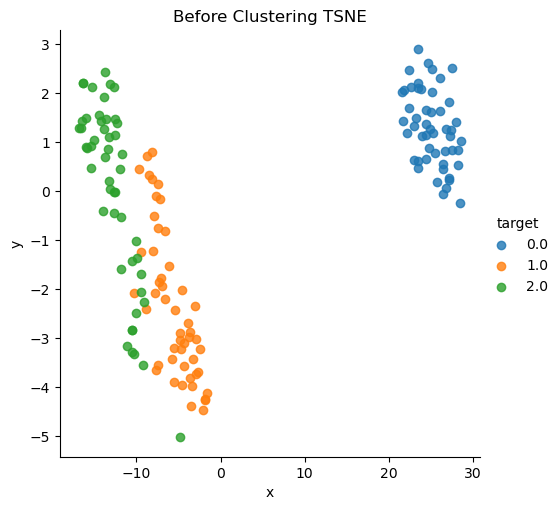

In [16]:
get_tsne_plot(X_iris_embedded, Y_iris, title="Before Clustering TSNE", save=True, img_name='iris/before_clustering.png')

In [18]:
extrinsic_kmeans_iris, instrinsic_kmeans_iris = kmeans_hyperparameter_tuning(X_iris, Y_iris, n_cluster=3, max_iters=[10, 30, 50, 70])
print("Intrinsic Measures: k-means for iris dataset")
print_all_intrinsic(instrinsic_kmeans_iris)
print("-----------------------")
print("Extrinsic Measures: k-means for iris dataset")
print_all_extrinsic(extrinsic_kmeans_iris)

Intrinsic Measures: k-means for iris dataset
10 : {'silhoutte_coefficient': 0.5528190123564095, 'calinski_harabasz_index': 561.62775662962, 'davies_bouldin_index': 0.6619715465007484}
30 : {'silhoutte_coefficient': 0.5528190123564095, 'calinski_harabasz_index': 561.62775662962, 'davies_bouldin_index': 0.6619715465007484}
50 : {'silhoutte_coefficient': 0.5528190123564095, 'calinski_harabasz_index': 561.62775662962, 'davies_bouldin_index': 0.6619715465007484}
70 : {'silhoutte_coefficient': 0.5528190123564095, 'calinski_harabasz_index': 561.62775662962, 'davies_bouldin_index': 0.6619715465007484}
-----------------------
Extrinsic Measures: k-means for iris dataset
10 : {'adjusted_rand_index': 0.7302382722834697, 'adjusted_mutual_information': 0.7551191675800483}
30 : {'adjusted_rand_index': 0.7302382722834697, 'adjusted_mutual_information': 0.7551191675800485}
50 : {'adjusted_rand_index': 0.7302382722834697, 'adjusted_mutual_information': 0.7551191675800485}
70 : {'adjusted_rand_index': 0

{'adjusted_rand_index': 0.7302382722834697, 'adjusted_mutual_information': 0.7551191675800483}
{'silhoutte_coefficient': 0.5528190123564095, 'calinski_harabasz_index': 561.62775662962, 'davies_bouldin_index': 0.6619715465007484}


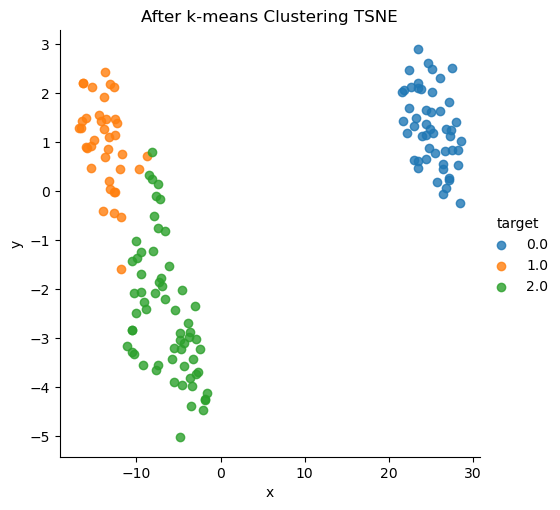

In [19]:
kmeans_model_iris = get_kmeans_model(n_clusters=3, max_iter=30)
kmeans_model_iris, kmeans_clusters_iris = perform_kmeans_clustering(kmeans_model_iris, X_iris)
get_tsne_plot(X_iris_embedded, kmeans_clusters_iris, title="After k-means Clustering TSNE", save=True, img_name='iris/kmeans_TSNE.png')
print(extrinsic_measures(Y_iris, kmeans_clusters_iris))
print(intrinsic_measures(X_iris, kmeans_clusters_iris))

In [21]:
extrinsic_kmedoids_iris, instrinsic_kmedoids_iris = kmedoids_hyperparameter_tuning(X_iris, Y_iris, n_cluster=3, metrics=['euclidean', 'cosine', 'manhattan'], inits=['heuristic', 'k-medoids++'])
print("Intrinsic Measures: k-means for iris dataset")
print_all_intrinsic(instrinsic_kmedoids_iris)
print("-----------------------")
print("Extrinsic Measures: k-means for iris dataset")
print_all_extrinsic(extrinsic_kmedoids_iris)

Intrinsic Measures: k-means for iris dataset
('euclidean', 'heuristic') : {'silhoutte_coefficient': 0.5201984013106983, 'calinski_harabasz_index': 521.5609065033622, 'davies_bouldin_index': 0.668624441042894}
('euclidean', 'k-medoids++') : {'silhoutte_coefficient': 0.5528190123564095, 'calinski_harabasz_index': 561.62775662962, 'davies_bouldin_index': 0.6619715465007484}
('cosine', 'heuristic') : {'silhoutte_coefficient': 0.48834283134326634, 'calinski_harabasz_index': 462.84408747980956, 'davies_bouldin_index': 0.7775421080005375}
('cosine', 'k-medoids++') : {'silhoutte_coefficient': 0.48834283134326634, 'calinski_harabasz_index': 462.84408747980956, 'davies_bouldin_index': 0.7775421080005375}
('manhattan', 'heuristic') : {'silhoutte_coefficient': 0.5182716402160823, 'calinski_harabasz_index': 520.6493562540924, 'davies_bouldin_index': 0.6762172329018474}
('manhattan', 'k-medoids++') : {'silhoutte_coefficient': 0.5182716402160823, 'calinski_harabasz_index': 520.6493562540921, 'davies_

{'adjusted_rand_index': 0.7302382722834697, 'adjusted_mutual_information': 0.7551191675800483}
{'silhoutte_coefficient': 0.5528190123564095, 'calinski_harabasz_index': 561.62775662962, 'davies_bouldin_index': 0.6619715465007484}


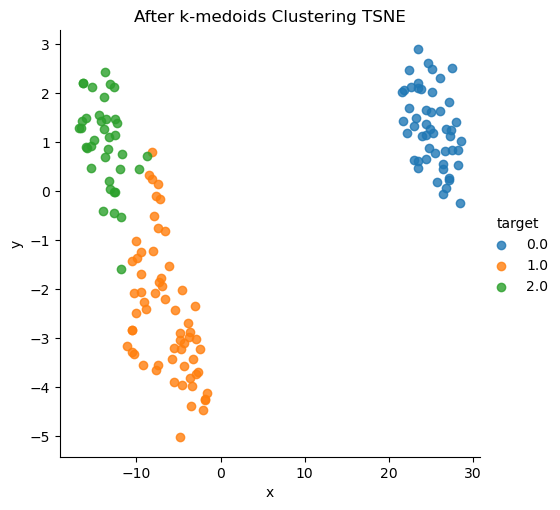

In [22]:
kmedoids_model_iris = get_kmedoids_model(n_clusters=3, metric='euclidean', init='k-medoids++')
kmedoids_model_iris, kmedoids_clusters_iris = perform_kmedoids_clustering(kmedoids_model_iris, X_iris)
get_tsne_plot(X_iris_embedded, kmedoids_clusters_iris, title="After k-medoids Clustering TSNE", save=True, img_name='iris/kmedoids_TSNE.png')
print(extrinsic_measures(Y_iris, kmedoids_clusters_iris))
print(intrinsic_measures(X_iris, kmedoids_clusters_iris))

In [24]:
extrinsic_spectral_iris, instrinsic_spectral_iris = spectral_hyperparameter_tuning(X_iris, Y_iris, n_clusters=3, affinities=['rbf', 'nearest_neighbors'], n_components_list=[1, 2, 3])
print("Intrinsic Measures: spectral for iris dataset")
print_all_intrinsic(instrinsic_spectral_iris)
print("-----------------------")
print("Extrinsic Measures: spectral for iris dataset")
print_all_extrinsic(extrinsic_spectral_iris)

Intrinsic Measures: spectral for iris dataset
('rbf', 1) : {'silhoutte_coefficient': 0.4288748900727913, 'calinski_harabasz_index': 285.49477488338357, 'davies_bouldin_index': 1.4554180012449347}
('rbf', 2) : {'silhoutte_coefficient': 0.4573709947703885, 'calinski_harabasz_index': 286.65435519028364, 'davies_bouldin_index': 0.460643232246674}
('rbf', 3) : {'silhoutte_coefficient': 0.5553062646081594, 'calinski_harabasz_index': 556.11769190375, 'davies_bouldin_index': 0.6538599267578228}
('nearest_neighbors', 1) : {'silhoutte_coefficient': 0.6867350732769777, 'calinski_harabasz_index': 502.82156350235897, 'davies_bouldin_index': 0.38275284210068705}
('nearest_neighbors', 2) : {'silhoutte_coefficient': 0.41250477425203647, 'calinski_harabasz_index': 251.54376819468678, 'davies_bouldin_index': 2.4845536956876537}
('nearest_neighbors', 3) : {'silhoutte_coefficient': 0.5541608580282851, 'calinski_harabasz_index': 556.8795419179528, 'davies_bouldin_index': 0.6584442783224304}
---------------

{'adjusted_rand_index': 0.7591987071071522, 'adjusted_mutual_information': 0.8032287370935435}
{'silhoutte_coefficient': 0.5541608580282851, 'calinski_harabasz_index': 556.8795419179528, 'davies_bouldin_index': 0.6584442783224304}


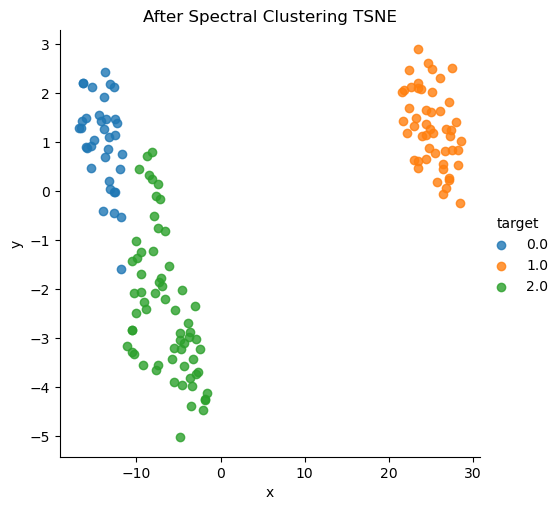

In [25]:
spectral_model_iris = get_spectral_model(n_clusters=3, affinity='nearest_neighbors', n_components=3)
spectral_model_iris, spectral_clusters_iris = perform_spectral_clustering(spectral_model_iris, X_iris)
get_tsne_plot(X_iris_embedded, spectral_clusters_iris, title="After Spectral Clustering TSNE", save=True, img_name='iris/spectral_TSNE.png')
print(extrinsic_measures(Y_iris, spectral_clusters_iris))
print(intrinsic_measures(X_iris, spectral_clusters_iris))

{'adjusted_rand_index': 0.04378690355509054, 'adjusted_mutual_information': 0.048434206502902026}
{'silhoutte_coefficient': -0.03856209479593506, 'calinski_harabasz_index': 0.5187659517665726, 'davies_bouldin_index': 35.39887442498115}


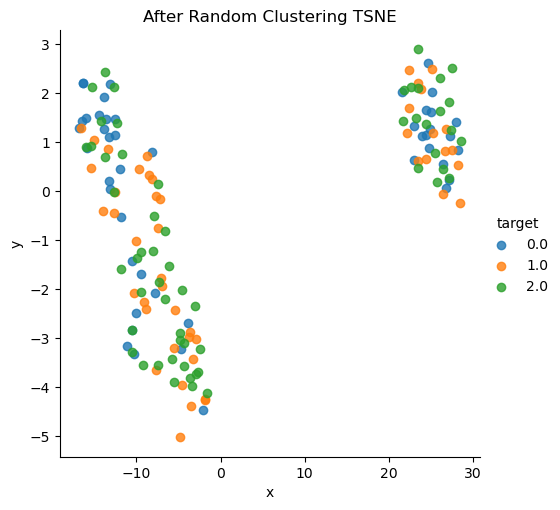

In [26]:
random_clusters_iris = perform_random_clustering(3, X_iris)
get_tsne_plot(X_iris_embedded, random_clusters_iris, title="After Random Clustering TSNE", save=True, img_name='iris/random_TSNE.png')
print(extrinsic_measures(Y_iris, random_clusters_iris))
print(intrinsic_measures(X_iris, random_clusters_iris))

Digit Dataset

In [27]:
digits = get_dataset('digits')
X_digits = digits.data
Y_digits = digits.target
X_digits_embedded = get_tsne(X_digits)

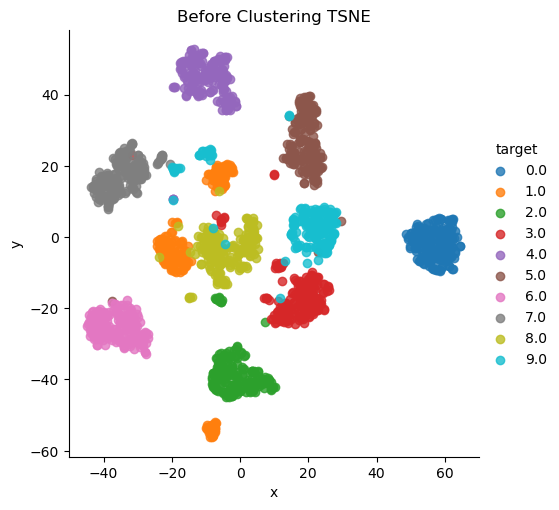

In [28]:
get_tsne_plot(X_digits_embedded, Y_digits, title="Before Clustering TSNE", save=True, img_name='digits/before_clustering.png')

In [29]:
extrinsic_kmeans_digits, intrinsic_kmeans_digits = kmeans_hyperparameter_tuning(X_digits, Y_digits, n_cluster=10, max_iters = [10, 30, 60, 80])
print("Intrinsic Measures: k-means for digit dataset")
print_all_intrinsic(intrinsic_kmeans_digits)
print("-----------------------")
print("Extrinsic Measures: k-means for digit dataset")
print_all_extrinsic(extrinsic_kmeans_digits)

Intrinsic Measures: k-means for digit dataset
10 : {'silhoutte_coefficient': 0.18562518179806078, 'calinski_harabasz_index': 167.68502256136833, 'davies_bouldin_index': 1.905977799121939}
30 : {'silhoutte_coefficient': 0.18236087870891401, 'calinski_harabasz_index': 169.379144993524, 'davies_bouldin_index': 1.9226417594433922}
60 : {'silhoutte_coefficient': 0.18214891629459068, 'calinski_harabasz_index': 169.19995996203832, 'davies_bouldin_index': 1.926643146128035}
80 : {'silhoutte_coefficient': 0.18215192762693486, 'calinski_harabasz_index': 169.3321844380272, 'davies_bouldin_index': 1.9167217396205078}
-----------------------
Extrinsic Measures: k-means for digit dataset
10 : {'adjusted_rand_index': 0.6469031961704855, 'adjusted_mutual_information': 0.7411022438095473}
30 : {'adjusted_rand_index': 0.666663866356343, 'adjusted_mutual_information': 0.7399044846092738}
60 : {'adjusted_rand_index': 0.662696204018353, 'adjusted_mutual_information': 0.7380717688155659}
80 : {'adjusted_ran

{'adjusted_rand_index': 0.6689567035719545, 'adjusted_mutual_information': 0.7413450081295662}
{'silhoutte_coefficient': 0.18242959371984133, 'calinski_harabasz_index': 169.3655418492578, 'davies_bouldin_index': 1.9223883446397978}


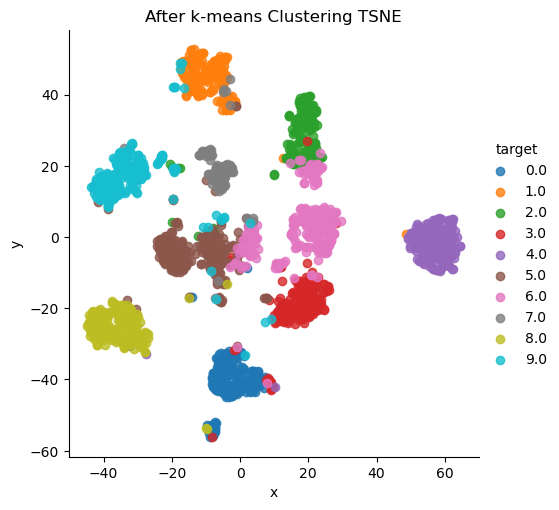

In [30]:
kmeans_model_digits = get_kmeans_model(n_clusters=10, max_iter=30)
kmeans_model_digits, kmeans_clusters_digits = perform_kmeans_clustering(kmeans_model_digits, X_digits)
get_tsne_plot(X_digits_embedded, kmeans_clusters_digits, title="After k-means Clustering TSNE", save=True, img_name='digits/kmeans_TSNE.png')
print(extrinsic_measures(Y_digits, kmeans_clusters_digits))
print(intrinsic_measures(X_digits, kmeans_clusters_digits))

In [32]:
extrinsic_kmedoids_digits, instrinsic_kmedoids_digits = kmedoids_hyperparameter_tuning(X_digits, Y_digits, n_cluster=10, metrics=['euclidean', 'cosine', 'manhattan'], inits=['heuristic', 'k-medoids++'])
print("Intrinsic Measures: k-medoids for digit dataset")
print_all_intrinsic(instrinsic_kmedoids_digits)
print("-----------------------")
print("Extrinsic Measures: k-medoids for digit dataset")
print_all_extrinsic(extrinsic_kmedoids_digits)

Intrinsic Measures: k-medoids for digit dataset
('euclidean', 'heuristic') : {'silhoutte_coefficient': 0.17364792838075688, 'calinski_harabasz_index': 163.18516135292944, 'davies_bouldin_index': 1.9809685214176604}
('euclidean', 'k-medoids++') : {'silhoutte_coefficient': 0.17364792838075688, 'calinski_harabasz_index': 163.1851613529295, 'davies_bouldin_index': 1.9809685214176604}
('cosine', 'heuristic') : {'silhoutte_coefficient': 0.1750535253464788, 'calinski_harabasz_index': 164.37721158748528, 'davies_bouldin_index': 1.9756855282817471}
('cosine', 'k-medoids++') : {'silhoutte_coefficient': 0.1750535253464788, 'calinski_harabasz_index': 164.37721158748525, 'davies_bouldin_index': 1.9756855282817476}
('manhattan', 'heuristic') : {'silhoutte_coefficient': 0.16675691276032603, 'calinski_harabasz_index': 157.86007802112064, 'davies_bouldin_index': 1.9755744380767837}
('manhattan', 'k-medoids++') : {'silhoutte_coefficient': 0.16650757515855974, 'calinski_harabasz_index': 157.6072609580820

{'adjusted_rand_index': 0.6503471906636054, 'adjusted_mutual_information': 0.7187681191581738}
{'silhoutte_coefficient': 0.17364792838075688, 'calinski_harabasz_index': 163.1851613529295, 'davies_bouldin_index': 1.9809685214176604}


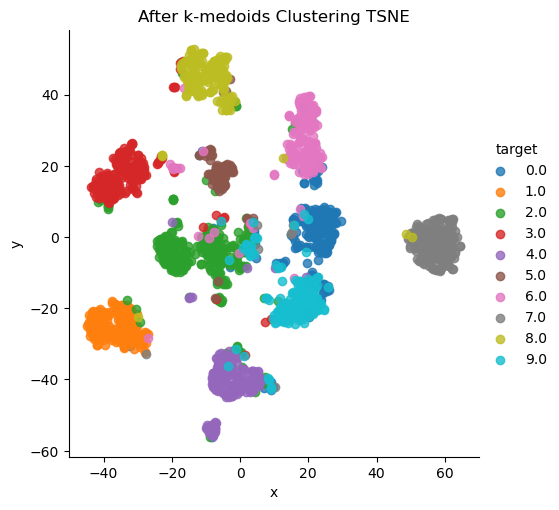

In [33]:
kmedoids_model_digits = get_kmedoids_model(n_clusters=10, metric = 'euclidean', init='k-medoids++')
kmedoids_model_digits, kmedoids_clusters_digits = perform_kmedoids_clustering(kmedoids_model_digits, X_digits)
get_tsne_plot(X_digits_embedded, kmedoids_clusters_digits, title="After k-medoids Clustering TSNE", save=True, img_name='digits/kmedoids_TSNE.png')
print(extrinsic_measures(Y_digits, kmedoids_clusters_digits))
print(intrinsic_measures(X_digits, kmedoids_clusters_digits))

In [34]:
X_digits_sample1, X_digits_sample, Y_digits_sample1, Y_digits_sample = train_test_split(X_digits, Y_digits, test_size=0.4, stratify=Y_digits)
X_digits_sample_embedded = get_tsne(X_digits_sample)

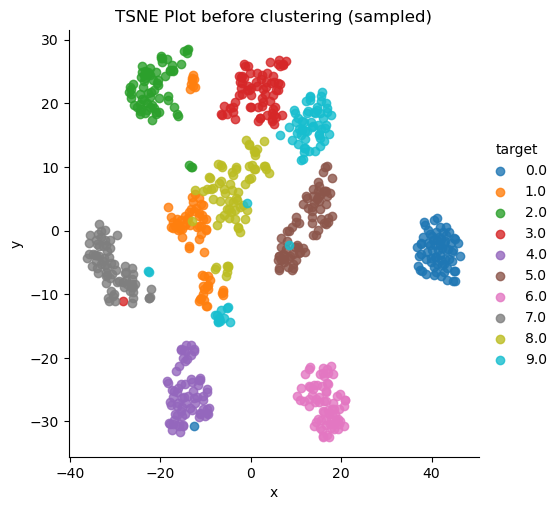

In [35]:
get_tsne_plot(X_digits_sample_embedded, Y_digits_sample, title='TSNE Plot before clustering (sampled)', save=True, img_name = 'digits/before_clustering_spectral.png')

In [36]:
extrinsic_spectral_digits, instrinsic_spectral_digits = spectral_hyperparameter_tuning(X_digits_sample, Y_digits_sample, n_clusters=10, affinities=['rbf', 'nearest_neighbors'], n_components_list=[2, 4, 8, 10])
print("Intrinsic Measures: spectral for digit dataset")
print_all_intrinsic(instrinsic_spectral_digits)
print("-----------------------")
print("Extrinsic Measures: spectral for digit dataset")
print_all_extrinsic(extrinsic_spectral_digits)

Intrinsic Measures: spectral for digit dataset
('rbf', 2) : {'silhoutte_coefficient': -0.21006296708263417, 'calinski_harabasz_index': 0.8665205033342854, 'davies_bouldin_index': 1.0925523684896998}
('rbf', 4) : {'silhoutte_coefficient': -0.19815526155491198, 'calinski_harabasz_index': 0.8776595732246757, 'davies_bouldin_index': 1.3915479491047882}
('rbf', 8) : {'silhoutte_coefficient': -0.207340379525724, 'calinski_harabasz_index': 0.9023684039598481, 'davies_bouldin_index': 1.0735628472214627}
('rbf', 10) : {'silhoutte_coefficient': -0.21006296708263417, 'calinski_harabasz_index': 0.8665205033342854, 'davies_bouldin_index': 1.0925523684896998}
('nearest_neighbors', 2) : {'silhoutte_coefficient': 0.05352989490836894, 'calinski_harabasz_index': 34.6181085732114, 'davies_bouldin_index': 2.6920434325675417}
('nearest_neighbors', 4) : {'silhoutte_coefficient': 0.13417236782275932, 'calinski_harabasz_index': 51.82413144402912, 'davies_bouldin_index': 2.130782988781788}
('nearest_neighbors'

{'adjusted_rand_index': 0.7337913275484396, 'adjusted_mutual_information': 0.8223242486341953}
{'silhoutte_coefficient': 0.17939546647882051, 'calinski_harabasz_index': 66.42548088914748, 'davies_bouldin_index': 1.939764314620943}


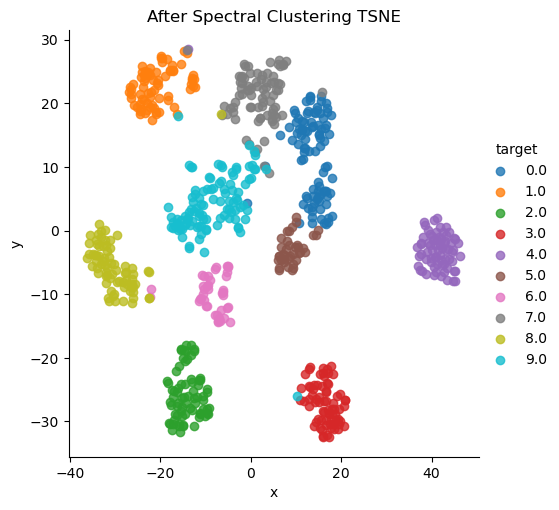

In [37]:
spectral_model_digits = get_spectral_model(n_clusters=10, affinity='nearest_neighbors', n_components=10)
spectral_model_digits, spectral_clusters_digits = perform_spectral_clustering(spectral_model_digits, X_digits_sample)
get_tsne_plot(X_digits_sample_embedded, spectral_clusters_digits, title="After Spectral Clustering TSNE", save=True, img_name='digits/spectral_TSNE.png')
print(extrinsic_measures(Y_digits_sample, spectral_clusters_digits))
print(intrinsic_measures(X_digits_sample, spectral_clusters_digits))

{'adjusted_rand_index': -0.0004457871900047615, 'adjusted_mutual_information': -0.0010044616459200138}
{'silhoutte_coefficient': -0.018159166854004375, 'calinski_harabasz_index': 1.0944927830297015, 'davies_bouldin_index': 23.786742080402913}


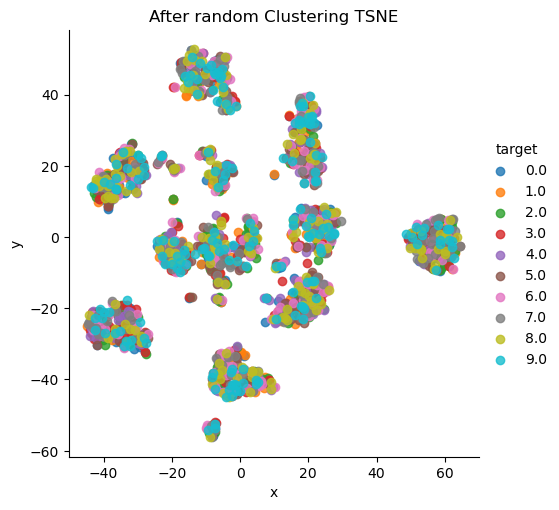

In [38]:
random_clusters_digits = perform_random_clustering(10, X_digits)
get_tsne_plot(X_digits_embedded, random_clusters_digits, title="After random Clustering TSNE", save=True, img_name='digits/random_TSNE.png')
print(extrinsic_measures(Y_digits, random_clusters_digits))
print(intrinsic_measures(X_digits, random_clusters_digits))

Credit-card Fraud

In [42]:
data_credit_card = get_dataset('credit_card')
X_credit = data_credit_card.data
Y_credit = data_credit_card.target
X_credit_embedded = get_tsne(X_credit)

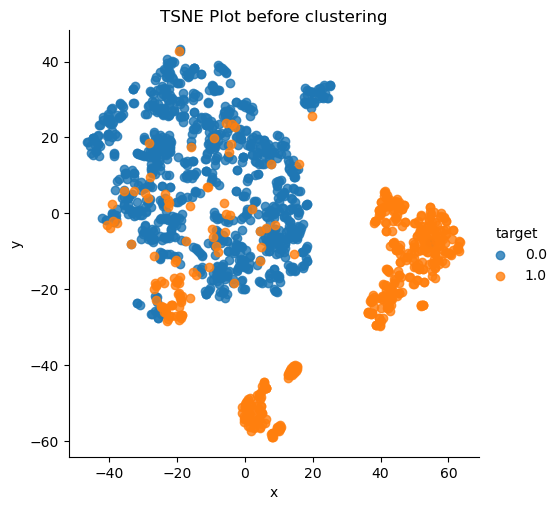

In [43]:
get_tsne_plot(X_credit_embedded, Y_credit, title = 'TSNE Plot before clustering', save = True, img_name = 'credit/before_clustering.png')

In [44]:
extrinsic_kmeans_credit, intrinsic_kmeans_credit = kmeans_hyperparameter_tuning(X_credit, Y_credit, n_cluster=2, max_iters = [10, 30, 50, 80])
print("Intrinsic Measures: k-means for credit dataset")
print_all_intrinsic(intrinsic_kmeans_credit)
print("-----------------------")
print("Extrinsic Measures: k-means for credit dataset")
print_all_extrinsic(extrinsic_kmeans_credit)

Intrinsic Measures: k-means for credit dataset
10 : {'silhoutte_coefficient': 0.5763222210236703, 'calinski_harabasz_index': 1590.2559520239981, 'davies_bouldin_index': 0.8402155296232907}
30 : {'silhoutte_coefficient': 0.5760575869008722, 'calinski_harabasz_index': 1590.281634239449, 'davies_bouldin_index': 0.8416228098539206}
50 : {'silhoutte_coefficient': 0.5763222210236703, 'calinski_harabasz_index': 1590.2559520239981, 'davies_bouldin_index': 0.8402155296232907}
80 : {'silhoutte_coefficient': 0.573864099656229, 'calinski_harabasz_index': 1590.1166434988945, 'davies_bouldin_index': 0.8484985732078886}
-----------------------
Extrinsic Measures: k-means for credit dataset
10 : {'adjusted_rand_index': 0.44735196522872234, 'adjusted_mutual_information': 0.4274199384684681}
30 : {'adjusted_rand_index': 0.4494139226660936, 'adjusted_mutual_information': 0.4290567304254464}
50 : {'adjusted_rand_index': 0.44735196522872234, 'adjusted_mutual_information': 0.4274199384684681}
80 : {'adjuste

{'adjusted_rand_index': 0.46184172334067847, 'adjusted_mutual_information': 0.4389289923957658}
{'silhoutte_coefficient': 0.573864099656229, 'calinski_harabasz_index': 1590.1166434988945, 'davies_bouldin_index': 0.8484985732078886}


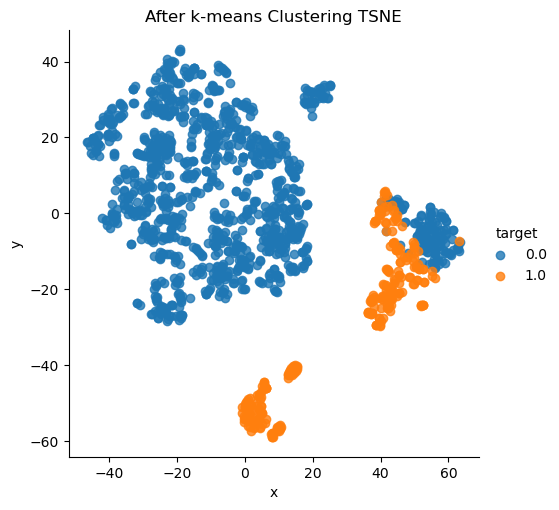

In [64]:
kmeans_model_credit = get_kmeans_model(n_clusters=2, max_iter=10)
kmeans_model_credit, kmeans_clusters_credit = perform_kmeans_clustering(kmeans_model_credit, X_credit)
get_tsne_plot(X_credit_embedded, kmeans_clusters_credit, title="After k-means Clustering TSNE", save=True, img_name='credit/kmeans_TSNE.png')
print(extrinsic_measures(Y_credit, kmeans_clusters_credit))
print(intrinsic_measures(X_credit, kmeans_clusters_credit))

In [46]:
extrinsic_kmedoids_credit, instrinsic_kmedoids_credit = kmedoids_hyperparameter_tuning(X_credit, Y_credit, n_cluster=2, metrics=['euclidean', 'cosine', 'manhattan'], inits=['heuristic', 'k-medoids++'])
print("Intrinsic Measures: k-medoids for credit dataset")
print_all_intrinsic(instrinsic_kmedoids_credit)
print("-----------------------")
print("Extrinsic Measures: k-medoids for credit dataset")
print_all_extrinsic(extrinsic_kmedoids_credit)

Intrinsic Measures: k-medoids for credit dataset
('euclidean', 'heuristic') : {'silhoutte_coefficient': 0.5482828908906328, 'calinski_harabasz_index': 1522.5571839307056, 'davies_bouldin_index': 0.9020260323490058}
('euclidean', 'k-medoids++') : {'silhoutte_coefficient': 0.5482828908906328, 'calinski_harabasz_index': 1522.5571839307056, 'davies_bouldin_index': 0.9020260323490058}
('cosine', 'heuristic') : {'silhoutte_coefficient': 0.579263441409982, 'calinski_harabasz_index': 1583.84238461178, 'davies_bouldin_index': 0.8361452932967766}
('cosine', 'k-medoids++') : {'silhoutte_coefficient': 0.579263441409982, 'calinski_harabasz_index': 1583.84238461178, 'davies_bouldin_index': 0.8361452932967766}
('manhattan', 'heuristic') : {'silhoutte_coefficient': 0.5514488624222316, 'calinski_harabasz_index': 1531.5206654722913, 'davies_bouldin_index': 0.8971767475761573}
('manhattan', 'k-medoids++') : {'silhoutte_coefficient': 0.5514488624222316, 'calinski_harabasz_index': 1531.5206654722913, 'davi

{'adjusted_rand_index': 0.5625420367650639, 'adjusted_mutual_information': 0.5199368443874973}
{'silhoutte_coefficient': 0.5482828908906328, 'calinski_harabasz_index': 1522.5571839307056, 'davies_bouldin_index': 0.9020260323490058}


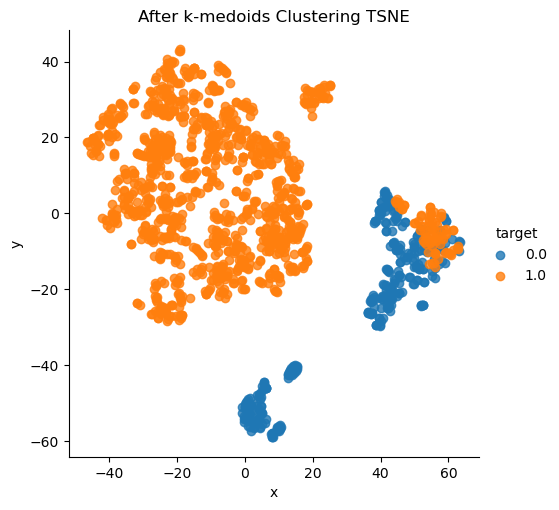

In [47]:
kmedoids_model_credit = get_kmedoids_model(n_clusters=2, metric='euclidean', init='k-medoids++')
kmedoids_model_credit, kmedoids_clusters_credit = perform_kmedoids_clustering(kmedoids_model_credit, X_credit)
get_tsne_plot(X_credit_embedded, kmedoids_clusters_credit, title="After k-medoids Clustering TSNE", save=True, img_name='credit/kmedoids_TSNE.png')
print(extrinsic_measures(Y_credit, kmedoids_clusters_credit))
print(intrinsic_measures(X_credit, kmedoids_clusters_credit))

In [60]:
extrinsic_spectral_credit, instrinsic_spectral_credit = spectral_hyperparameter_tuning(X_credit, Y_credit, n_clusters=2, affinities=['rbf', 'nearest_neighbors'], n_components_list=[1, 2])
print("Intrinsic Measures: Spectral for credit dataset")
print_all_intrinsic(instrinsic_spectral_credit)
print("-----------------------")
print("Extrinsic Measures: Spectral for credit dataset")
print_all_extrinsic(extrinsic_spectral_credit)

Intrinsic Measures: Spectral for credit dataset
('rbf', 1) : {'silhoutte_coefficient': 0.010541780507057511, 'calinski_harabasz_index': 18.571731527934595, 'davies_bouldin_index': 7.517694679549817}
('rbf', 2) : {'silhoutte_coefficient': 0.6269726332300141, 'calinski_harabasz_index': 1301.819013374994, 'davies_bouldin_index': 0.669409991267859}
('nearest_neighbors', 1) : {'silhoutte_coefficient': 0.4655990976649307, 'calinski_harabasz_index': 88.13351139199766, 'davies_bouldin_index': 0.5552601006401273}
('nearest_neighbors', 2) : {'silhoutte_coefficient': 0.6325429684314009, 'calinski_harabasz_index': 925.9070189065777, 'davies_bouldin_index': 0.5984310467378183}
-----------------------
Extrinsic Measures: Spectral for credit dataset
('rbf', 1) : {'adjusted_rand_index': 0.009520026918560952, 'adjusted_mutual_information': 0.00805923841734842}
('rbf', 2) : {'adjusted_rand_index': 0.20515699100063214, 'adjusted_mutual_information': 0.22927479937184442}
('nearest_neighbors', 1) : {'adjus

{'adjusted_rand_index': 0.20515699100063214, 'adjusted_mutual_information': 0.22927479937184442}
{'silhoutte_coefficient': 0.6269726332300141, 'calinski_harabasz_index': 1301.819013374994, 'davies_bouldin_index': 0.669409991267859}


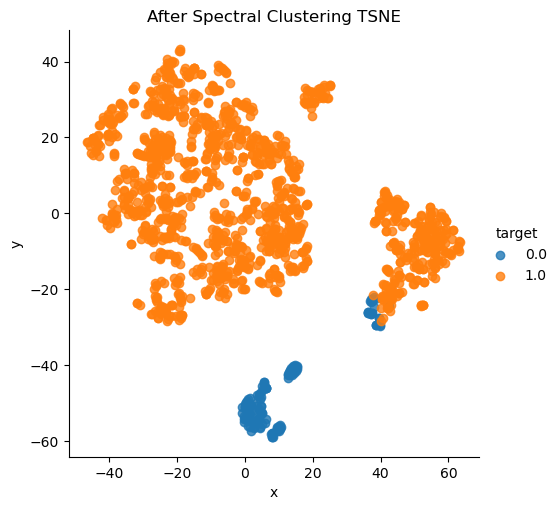

In [61]:
spectral_model_credit = get_spectral_model(n_clusters=2, affinity='rbf', n_components=2)
spectral_model_credit, spectral_clusters_credit = perform_spectral_clustering(spectral_model_credit, X_credit)
get_tsne_plot(X_credit_embedded, spectral_clusters_credit, title="After Spectral Clustering TSNE", save=True, img_name='credit/spectral_TSNE.png')
print(extrinsic_measures(Y_credit, spectral_clusters_credit))
print(intrinsic_measures(X_credit, spectral_clusters_credit))

{'adjusted_rand_index': -0.0005773358865637621, 'adjusted_mutual_information': -0.0005057243226267288}
{'silhoutte_coefficient': 0.0003295400501856345, 'calinski_harabasz_index': 0.7563464752279336, 'davies_bouldin_index': 37.25114570550437}


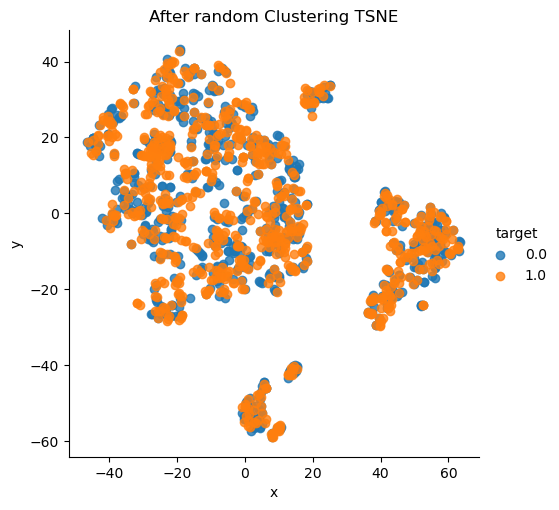

In [62]:
random_clusters_credit = perform_random_clustering(2, X_credit)
get_tsne_plot(X_credit_embedded, random_clusters_credit, title="After random Clustering TSNE", save=True, img_name='credit/random_TSNE.png')
print(extrinsic_measures(Y_credit, random_clusters_credit))
print(intrinsic_measures(X_credit, random_clusters_credit))